# Essential modules

In [4]:
import pandas as pd
from dataLoading import *
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Warning -> disabled
import warnings
warnings.filterwarnings("ignore")

ImportError: No module named 'sklearn.__check_build._check_build'
___________________________________________________________________________
Contents of D:\M.Sc. Data Science\Danesh kar\Python\Data science and machine learning\Task 2\venv\Lib\site-packages\sklearn\__check_build:
_check_build.cp311-win_amd64.pyd__init__.py               __pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

# Data loading and gain info

In [2]:
movie_dataset = pd.read_csv('tmdb_5000_movies.csv')
credit_dataset = pd.read_csv('tmdb_5000_credits.csv')

In [3]:
movie_dataset.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.437577,139.082615,107.376788,112.31295,43.926995
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"


In [4]:
credit_dataset.head().T

,0,1,2,3,4
movie_id,19995,285,206647,49026,49529
title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
cast,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."
crew,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Merging datasets

In [5]:
# Checking availability of datasets to merge
if (credit_dataset['movie_id'] != movie_dataset['id']).any().sum() == 0:
    print("movie_id and id are matched!")
    
else:
    print("movie_id and id are not matched! You have to consider some feature else")

movie_id and id are matched!


In [6]:
df = credit_dataset.merge(movie_dataset, right_on="id", left_on="movie_id", suffixes=('_movies', '_credits'))
df.drop(["id"], axis=1, inplace=True)
df.head().T

,0,1,2,3,4
movie_id,19995,285,206647,49026,49529
title_movies,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
cast,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."
crew,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter


In [7]:
# Define shape of df and check missing values
nrow, ncol = df.shape
print(f"Final dataset contain {nrow} rows and {ncol} columns")
print("=============================")
print(df.info())

Final dataset contain 4803 rows and 23 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              4803 non-null   int64  
 1   title_movies          4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          480

In [8]:
# Check duplicated values

df["movie_id"] = df["movie_id"].astype(str) # Change to str
if df["movie_id"].duplicated().sum() == 0:
    print("There is no duplicated value in dataset")
    
else:
    print(f"There are {df["movie_id"].duplicated().sum()} duplicated movies!")


There is no duplicated value in dataset


In [10]:
# Handling missing values with replacing by average
df["runtime"].fillna(df["runtime"].mean, inplace=True)

## Extract data from JSON files

In [11]:
# Convert to JSON
def convert_json(df, columns):
    for column in columns:
        df[column] = df[column].apply(json.loads)
    return df


df = convert_json(
    df,
    ["cast", "crew", "genres", "keywords", "production_companies", "production_countries", "spoken_languages"]
)


In [21]:
# Saving JSON to dataframe
cast_dataset = {df["title_movies"][0] : [df["cast"][0][0].get("name"), df["cast"][0][1].get("name")]}
print(cast_dataset)

{'Avatar': ['Sam Worthington', 'Zoe Saldana']}


In [23]:

cast_dataset.update({df["title_movies"][1] : [df["cast"][1][0].get("name"), df["cast"][1][1].get("name")]})
print(cast_dataset)

{'Avatar': ['Sam Worthington', 'Zoe Saldana'], "Pirates of the Caribbean: At World's End": ['Johnny Depp', 'Orlando Bloom']}


In [66]:
# Create cast dataset

cast_dataset = dict()
for i in range(len(df["title_movies"])):
    cast_dataset.update({df["title_movies"][i] : [df["cast"][i][j].get("name") for j in range(len(df["cast"][i]))]})

In [67]:
# Create genres dataset

genres_dataset = dict()
for i in range(len(df["title_movies"])):
    genres_dataset.update({df["title_movies"][i] : [df["genres"][i][j].get("name") for j in range(len(df["genres"][i]))]}) 

In [68]:
# Create keywords dataset

keywords_dataset = dict()
for i in range(len(df["title_movies"])):
    keywords_dataset.update({df["title_movies"][i] : [df["keywords"][i][j].get("name") for j in range(len(df["keywords"][i]))]}) 

In [69]:
# Create production company dataset
    
production_companies_dataset = dict()
for i in range(len(df["title_movies"])):
    production_companies_dataset.update({df["title_movies"][i] : [df["production_companies"][i][j].get("name") for j in range(len(df["production_companies"][i]))]}) 

In [70]:
# Create production countries dataset
    
production_countries_dataset = dict()
for i in range(len(df["title_movies"])):
    production_countries_dataset.update({df["title_movies"][i] : [df["production_countries"][i][j].get("name") for j in range(len(df["production_countries"][i]))]})

In [71]:
# Create spoken language dataset

spoken_languages_dataset = dict()
for i in range(len(df["title_movies"])):
    spoken_languages_dataset.update({df["title_movies"][i] : [df["spoken_languages"][i][j].get("name") for j in range(len(df["spoken_languages"][i]))]})

## Visualiazation

In [78]:
df.sort_values(by=["vote_average"], ascending=False)[["title_movies", "vote_count", "vote_average"]] 

,title_movies,vote_count,vote_average
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3992,Sardaarji,2,9.5
...,...,...,...
3960,The Deported,0,0.0
4684,American Beast,0,0.0
3967,Four Single Fathers,0,0.0
4486,Naturally Native,0,0.0


It seems is not accurate, because the highest score is Stiff Upper Lips with one vote (LOL)

It needs to recalculate with weighted average

In [86]:
# Calculation with IMDB formula
def weight_average(data, q = df["vote_count"].quantile(0.9), mean = df["vote_average"].mean()):
    vote_count = data["vote_count"]
    vote_average = data["vote_average"]
    
    return (vote_count / (vote_count + q) * vote_average) + (q / (q + vote_count) * mean)
    
   

![image info](./img/weight_average.png)

In [82]:
df["score"] = df.apply(weight_average, axis=1)

In [85]:
df.sort_values(by=["score"], ascending=False)[["title_movies", "vote_count", "vote_average", "score"]].head(10)

,title_movies,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


### Popularity

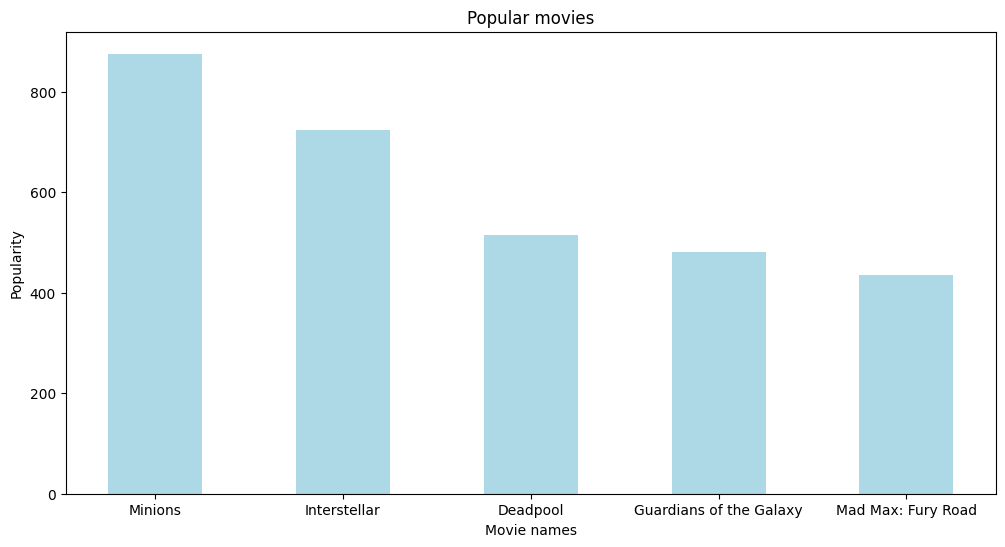

In [92]:
# Sort dataframe based on popularity
popularity = df.sort_values(by=["popularity"], ascending=False)

# Plot top 5 popular movies
plt.figure(figsize=(12, 6))
plt.bar(popularity["title_movies"].head(5), popularity["popularity"].head(5), align="center", width=0.5, color="lightblue")
plt.xlabel("Movie names")
plt.ylabel("Popularity")
plt.title("Popular movies")
plt.show()

## Machine learning